In [1]:
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(20)
tf.random.set_seed(20)
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
import pandas as pd

df = pd.read_csv('ETHUSD_1yrs_15MinInterval.csv')
df

,close,high,low,trade_count,open,time,volume,vwap,symbol
0,1582.440,1585.620,1577.7600,192,1585.620,2022-09-02 00:00:00+00:00,212.16843,1580.919336,ETH/USD
1,1579.440,1581.290,1572.8900,216,1580.820,2022-09-02 00:15:00+00:00,219.05909,1578.339255,ETH/USD
2,1578.120,1579.510,1576.3300,68,1578.800,2022-09-02 00:30:00+00:00,52.94392,1577.198163,ETH/USD
3,1582.210,1583.920,1576.8300,65,1577.880,2022-09-02 00:45:00+00:00,42.93882,1579.653387,ETH/USD
4,1572.630,1583.110,1571.3500,95,1581.950,2022-09-02 01:00:00+00:00,37.89738,1577.622017,ETH/USD
...,...,...,...,...,...,...,...,...,...
34924,1647.080,1648.930,1645.4765,0,1648.930,2023-08-31 23:00:00+00:00,0.00000,0.000000,ETH/USD
34925,1643.950,1647.950,1643.9500,0,1647.188,2023-08-31 23:15:00+00:00,0.00000,0.000000,ETH/USD
34926,1646.235,1646.235,1643.5000,0,1644.000,2023-08-31 23:30:00+00:00,0.00000,0.000000,ETH/USD
34927,1645.100,1646.975,1644.8565,0,1645.879,2023-08-31 23:45:00+00:00,0.00000,0.000000,ETH/USD


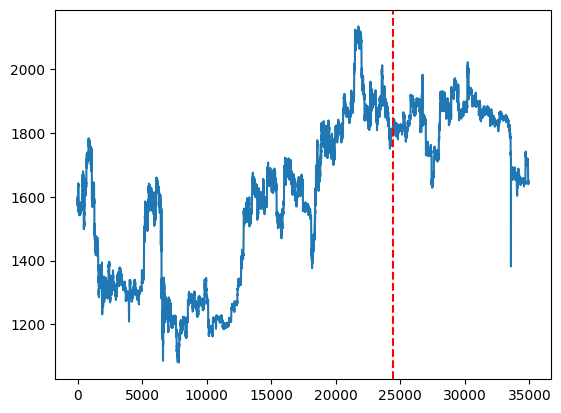

In [4]:
import matplotlib.pyplot as plt
import math

df['close'].plot()
splitat = math.floor(len(df) * 0.7)
plt.axvline(x=splitat, color='r', linestyle='--')

<AxesSubplot: >

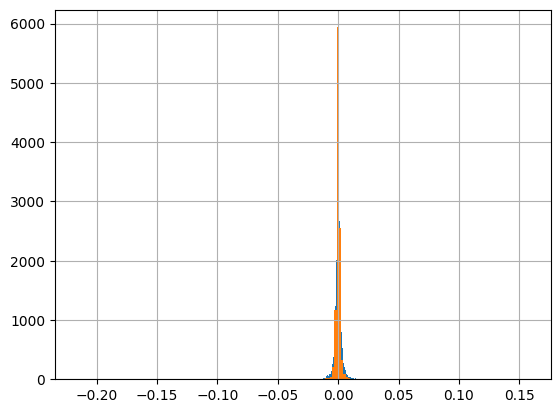

In [5]:
import numpy as np

df['log_return'] = np.log(df['close']).diff()
df['log_return'][:splitat].hist(bins=200)
df['log_return'][splitat:].hist(bins=200)

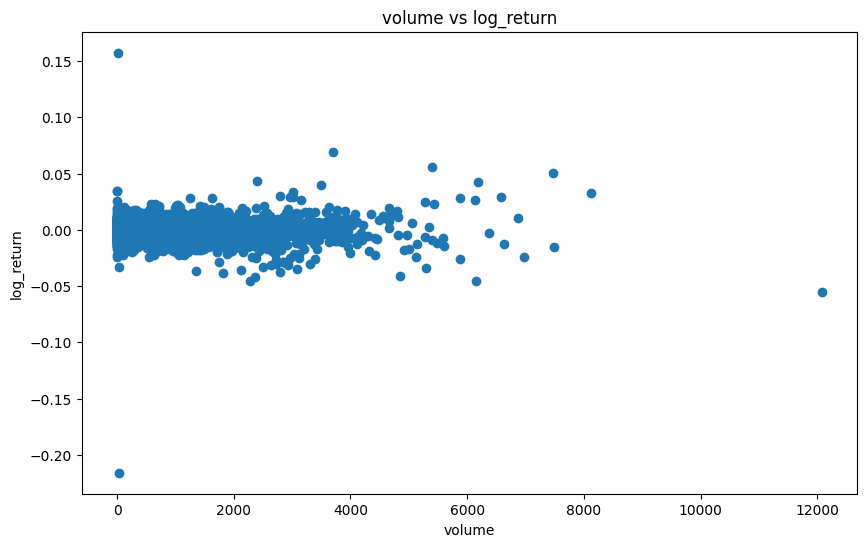

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(df['volume'], df['log_return'])
plt.xlabel('volume')
plt.ylabel('log_return')
plt.title('volume vs log_return')
plt.show()

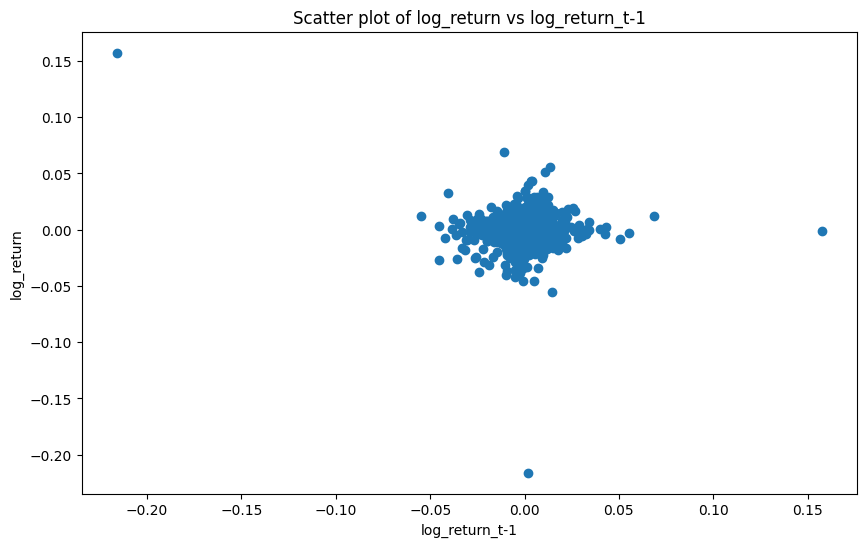

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(x=df['log_return'].shift(1), y=df['log_return'])
plt.title('Scatter plot of log_return vs log_return_t-1')
plt.xlabel('log_return_t-1')
plt.ylabel('log_return')
plt.show()

In [8]:
# Pearson correlation
correlation = df['log_return'].corr(df['log_return'].shift(1))
print('Pearson correlation:', correlation)

Pearson correlation: -0.07540722530225566


In [9]:
df['anomaly_return'] = (df['log_return'] > df['log_return'].quantile(0.90)).astype(int)
major = len(df[df['anomaly_return'] == 0])
minor = len(df[df['anomaly_return'] == 1])
print(f'Major: {major}\nMinor: {minor}\nRatio: {(major/(major+minor)):.4f}')

Major: 31436
Minor: 3493
Ratio: 0.9000


In [10]:
def balance_df(X_train, y_train, rate=1):
    df = pd.concat([X_train, y_train], axis=1)
    df_major = df[df['anomaly_return']==0]
    df_minor = df[df['anomaly_return']==1]
    major = len(df_major)
    minor = len(df_minor)

    if rate == 0.1:
        df_major = df_major.sample(n=minor, random_state=20)
        df = pd.concat([df_major, df_minor])
    elif rate == 1:
        df_minor = df_minor.sample(n=major, replace=True, random_state=20)
        df = pd.concat([df_major, df_minor])
    else:
        df_minor = df_minor.sample(n=math.floor(major*rate), replace=True, random_state=20)
        df_major = df_major.sample(n=len(df_minor), random_state=20)
        df = pd.concat([df_major, df_minor])
    
    X_train = df.drop(['anomaly_return'], axis=1)
    y_train = df['anomaly_return']
    return X_train, y_train

#df = balance_df(df, rate=0.2)
#major = len(df[df['anomaly_return'] == 0])
#minor = len(df[df['anomaly_return'] == 1])
#print(f'Major: {major}\nMinor: {minor}\nRatio: {(major/(major+minor)):.4f}')

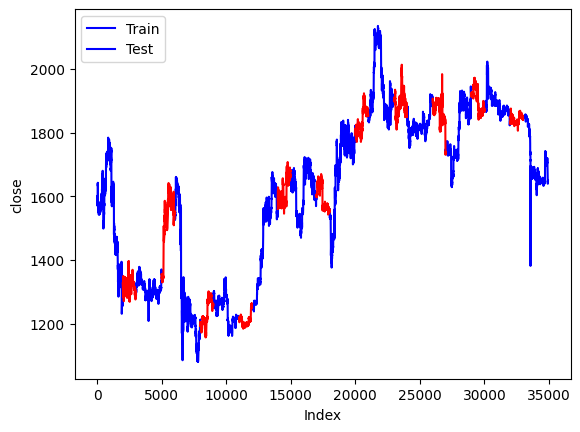

In [11]:
train_length = 2000  # Length of 'Train' sections
test_length = 1000  # Length of 'Test' sections

df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]

# split the dataframe
df_train = df[df['train'] == True]
df_test = df[df['train'] == False]

# find the start and end of each section
starts_train = df_train.index[::train_length]
ends_train = np.append(starts_train[1:] - 1, df_train.index[-1])
starts_test = df_test.index[::test_length]
ends_test = np.append(starts_test[1:] - 1, df_test.index[-1])

# plot each section separately
for start, end in zip(starts_train, ends_train):
    plt.plot(df_train.loc[start:end].index, df_train.loc[start:end]['close'], 'b')
for start, end in zip(starts_test, ends_test):
    plt.plot(df_test.loc[start:end].index, df_test.loc[start:end]['close'], 'r')

plt.xlabel('Index')
plt.ylabel('close')
plt.legend(['Train', 'Test'])
plt.show()

<AxesSubplot: >

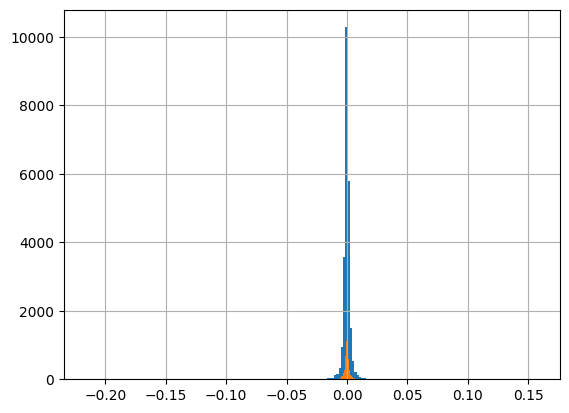

In [12]:
df_train['log_return'].hist(bins=200)
df_test['log_return'].hist(bins=200)

In [13]:
len(df_train), len(df_test)

(23929, 11000)

<AxesSubplot: >

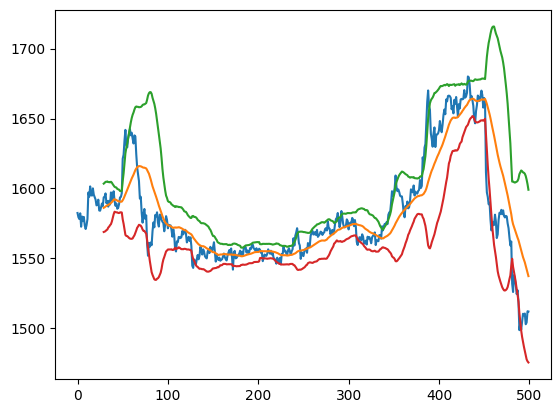

In [14]:
# Add SMA
def SMA(data, period=30, column='close'):
    return data[column].rolling(window=period).mean()

# Add Bollinger Bands
def BollingerBands(data, period=30, column='close'):
    sma = SMA(data, period, column=column)
    rolling_std = data[column].rolling(window=period).std()
    upper_band = sma + (rolling_std * 2)
    lower_band = sma - (rolling_std * 2)
    return upper_band, sma, lower_band

# Add RSI
def RSI(data, period=14, column='close'):
    delta = data[column].diff(1)
    loss = (delta.where(delta < 0, 0)).abs()
    gain = (delta.where(delta > 0, 0))
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_indicators(df):
    df['sma'] = SMA(df)
    df['upper_band'], df['middle_band'], df['lower_band'] = BollingerBands(df)
    df['rsi'] = RSI(df)
    return df

df = add_indicators(df)
df['close'][:500].plot()
df['sma'][:500].plot()
df['upper_band'][:500].plot()
df['lower_band'][:500].plot()

<AxesSubplot: >

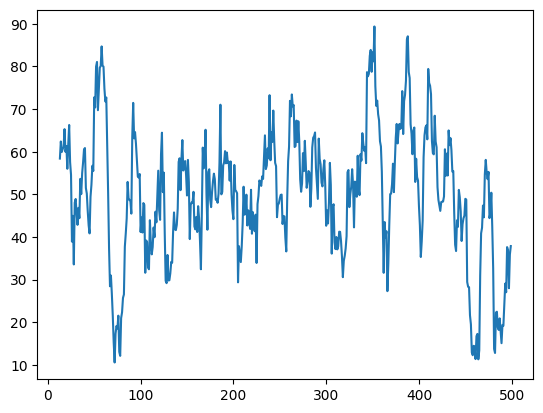

In [15]:
df['rsi'][:500].plot()

In [16]:
def redefine_indicators(df):
    df['sma'] = df['sma'] / df['close']
    df['upper_band'], df['middle_band'], df['lower_band'] = df['upper_band']/ df['close'], df['middle_band']/ df['close'], df['lower_band']/ df['close']
    df['rsi'] = RSI(df) / 50
    return df

df = redefine_indicators(df)
df

,close,high,low,trade_count,open,time,volume,vwap,symbol,log_return,anomaly_return,train,sma,upper_band,middle_band,lower_band,rsi
0,1582.440,1585.620,1577.7600,192,1585.620,2022-09-02 00:00:00+00:00,212.16843,1580.919336,ETH/USD,NaN,0,True,NaN,NaN,NaN,NaN,NaN
1,1579.440,1581.290,1572.8900,216,1580.820,2022-09-02 00:15:00+00:00,219.05909,1578.339255,ETH/USD,-0.001898,0,True,NaN,NaN,NaN,NaN,NaN
2,1578.120,1579.510,1576.3300,68,1578.800,2022-09-02 00:30:00+00:00,52.94392,1577.198163,ETH/USD,-0.000836,0,True,NaN,NaN,NaN,NaN,NaN
3,1582.210,1583.920,1576.8300,65,1577.880,2022-09-02 00:45:00+00:00,42.93882,1579.653387,ETH/USD,0.002588,1,True,NaN,NaN,NaN,NaN,NaN
4,1572.630,1583.110,1571.3500,95,1581.950,2022-09-02 01:00:00+00:00,37.89738,1577.622017,ETH/USD,-0.006073,0,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34924,1647.080,1648.930,1645.4765,0,1648.930,2023-08-31 23:00:00+00:00,0.00000,0.000000,ETH/USD,-0.001337,0,True,1.005616,1.019819,1.005616,0.991413,0.740167
34925,1643.950,1647.950,1643.9500,0,1647.188,2023-08-31 23:15:00+00:00,0.00000,0.000000,ETH/USD,-0.001902,0,True,1.006615,1.018947,1.006615,0.994284,0.664104
34926,1646.235,1646.235,1643.5000,0,1644.000,2023-08-31 23:30:00+00:00,0.00000,0.000000,ETH/USD,0.001389,0,True,1.004408,1.014533,1.004408,0.994284,0.787517
34927,1645.100,1646.975,1644.8565,0,1645.879,2023-08-31 23:45:00+00:00,0.00000,0.000000,ETH/USD,-0.000690,0,True,1.004393,1.012647,1.004393,0.996138,0.731005


In [17]:
def applylogdiff(df):
    for col in df.columns:
        if col not in ['log_return','time','symbol','train','anomaly_return']:
            df[col+'_logdiff'] = np.log(df[col]).diff()
            df = df.drop([col], axis=1)
    return df

df = applylogdiff(df)
df = df.drop(['time','symbol'], axis=1)
df

,log_return,anomaly_return,train,close_logdiff,high_logdiff,low_logdiff,trade_count_logdiff,open_logdiff,volume_logdiff,vwap_logdiff,sma_logdiff,upper_band_logdiff,middle_band_logdiff,lower_band_logdiff,rsi_logdiff
0,NaN,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.001898,0,True,-0.001898,-0.002735,-0.003091,0.117783,-3.031798e-03,0.031961,-0.001633,NaN,NaN,NaN,NaN,NaN
2,-0.000836,0,True,-0.000836,-0.001126,0.002185,-1.155771,-1.278635e-03,-1.420108,-0.000723,NaN,NaN,NaN,NaN,NaN
3,0.002588,1,True,0.002588,0.002788,0.000317,-0.045120,-5.828909e-04,-0.209457,0.001555,NaN,NaN,NaN,NaN,NaN
4,-0.006073,0,True,-0.006073,-0.000512,-0.003481,0.379490,2.576089e-03,-0.124894,-0.001287,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34924,-0.001337,0,True,-0.001337,-0.000214,-0.000168,NaN,1.292582e-03,NaN,NaN,0.000550,-0.000706,0.000550,1.843333e-03,-0.199845
34925,-0.001902,0,True,-0.001902,-0.000595,-0.000928,NaN,-1.057001e-03,NaN,NaN,0.000993,-0.000855,0.000993,2.891208e-03,-0.108437
34926,0.001389,0,True,0.001389,-0.001041,-0.000274,NaN,-1.937295e-03,NaN,NaN,-0.002195,-0.004341,-0.002195,-2.638571e-07,0.170446
34927,-0.000690,0,True,-0.000690,0.000449,0.000825,NaN,1.142291e-03,NaN,NaN,-0.000016,-0.001861,-0.000016,1.863456e-03,-0.074464


In [18]:
import warnings

def applylag(df, laglength=10):
    warnings.filterwarnings('ignore')
    for col in df.columns:
        for i in range(1, laglength+1):
            df[col+'_t-'+str(i)] = df[col].shift(i)
    return df

df = applylag(df, laglength=10)
df

,log_return,anomaly_return,train,close_logdiff,high_logdiff,low_logdiff,trade_count_logdiff,open_logdiff,volume_logdiff,vwap_logdiff,...,rsi_logdiff_t-1,rsi_logdiff_t-2,rsi_logdiff_t-3,rsi_logdiff_t-4,rsi_logdiff_t-5,rsi_logdiff_t-6,rsi_logdiff_t-7,rsi_logdiff_t-8,rsi_logdiff_t-9,rsi_logdiff_t-10
0,NaN,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.001898,0,True,-0.001898,-0.002735,-0.003091,0.117783,-3.031798e-03,0.031961,-0.001633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.000836,0,True,-0.000836,-0.001126,0.002185,-1.155771,-1.278635e-03,-1.420108,-0.000723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002588,1,True,0.002588,0.002788,0.000317,-0.045120,-5.828909e-04,-0.209457,0.001555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.006073,0,True,-0.006073,-0.000512,-0.003481,0.379490,2.576089e-03,-0.124894,-0.001287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34924,-0.001337,0,True,-0.001337,-0.000214,-0.000168,NaN,1.292582e-03,NaN,NaN,...,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471,-0.279936,-0.144388,-0.218811
34925,-0.001902,0,True,-0.001902,-0.000595,-0.000928,NaN,-1.057001e-03,NaN,NaN,...,-0.199845,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471,-0.279936,-0.144388
34926,0.001389,0,True,0.001389,-0.001041,-0.000274,NaN,-1.937295e-03,NaN,NaN,...,-0.108437,-0.199845,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471,-0.279936
34927,-0.000690,0,True,-0.000690,0.000449,0.000825,NaN,1.142291e-03,NaN,NaN,...,0.170446,-0.108437,-0.199845,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471


In [19]:
def remove_leaks(df, laglength=10, verbose=True):
    df['leaks'] = (df['train']) & (df['train'].shift(laglength) == False)
    leaks = len(df[df['leaks']])
    df = df[df['leaks']==False]
    df = df.drop('leaks',axis=1)
    if verbose:
        print(f'{leaks} leaks removed.')
    return df

df = remove_leaks(df, laglength=10)
df

110 leaks removed.


,log_return,anomaly_return,train,close_logdiff,high_logdiff,low_logdiff,trade_count_logdiff,open_logdiff,volume_logdiff,vwap_logdiff,...,rsi_logdiff_t-1,rsi_logdiff_t-2,rsi_logdiff_t-3,rsi_logdiff_t-4,rsi_logdiff_t-5,rsi_logdiff_t-6,rsi_logdiff_t-7,rsi_logdiff_t-8,rsi_logdiff_t-9,rsi_logdiff_t-10
0,NaN,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.001898,0,True,-0.001898,-0.002735,-0.003091,0.117783,-3.031798e-03,0.031961,-0.001633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.000836,0,True,-0.000836,-0.001126,0.002185,-1.155771,-1.278635e-03,-1.420108,-0.000723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002588,1,True,0.002588,0.002788,0.000317,-0.045120,-5.828909e-04,-0.209457,0.001555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.006073,0,True,-0.006073,-0.000512,-0.003481,0.379490,2.576089e-03,-0.124894,-0.001287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34924,-0.001337,0,True,-0.001337,-0.000214,-0.000168,NaN,1.292582e-03,NaN,NaN,...,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471,-0.279936,-0.144388,-0.218811
34925,-0.001902,0,True,-0.001902,-0.000595,-0.000928,NaN,-1.057001e-03,NaN,NaN,...,-0.199845,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471,-0.279936,-0.144388
34926,0.001389,0,True,0.001389,-0.001041,-0.000274,NaN,-1.937295e-03,NaN,NaN,...,-0.108437,-0.199845,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471,-0.279936
34927,-0.000690,0,True,-0.000690,0.000449,0.000825,NaN,1.142291e-03,NaN,NaN,...,0.170446,-0.108437,-0.199845,0.063310,0.133094,0.043617,0.023066,0.259014,-0.174664,0.174471


In [20]:
df['log_return'].quantile(0.90)

0.0024706813917607204

In [21]:
# get the next day return
df['log_return'] = df['log_return'].shift(-1)

# convert log_return >0.9 quantitle to binary
df['anomaly_return'] = (df['log_return'] > df['log_return'].quantile(0.90)).astype(int)

# drop the null value created by the lag function
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


# split the dataframe
X_train = df[df['train'] == True].drop(['log_return','train','anomaly_return'], axis=1)
X_test = df[df['train'] == False].drop(['log_return','train','anomaly_return'], axis=1)
y_train = df[df['train'] == True]['anomaly_return']
y_test = df[df['train'] == False]['anomaly_return']
print(f'X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_train:{len(y_test)}')

X_train:18304
X_test:9005
y_train:18304
y_train:9005


In [22]:
def process_data(indicators=True, laglength=10, val=False, verbose=True):
    df = pd.read_csv('ETHUSD_1yrs_15MinInterval.csv')
    df['log_return'] = np.log(df['close']).diff()
    df['train'] = [True if i % (train_length + test_length) < train_length else False for i in range(len(df))]
    df['log_return'] = df['log_return'].shift(-1)
    df['anomaly_return'] = (df['log_return'] > df['log_return'].quantile(0.90)).astype(int)
    if indicators:
        df = add_indicators(df)
        df = redefine_indicators(df)
    df = applylogdiff(df)
    df = df.drop(['time','symbol'], axis=1)
    df = applylag(df, laglength=laglength)
    df = remove_leaks(df, laglength=laglength, verbose=verbose)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # split the dataframe
    df_train = df[df['train'] == True]
    df_test = df[df['train'] == False]
    
    if val:
        # get a vaildation set from train set
        df_trainset, df_valset = train_test_split(df_train, test_size=0.2, random_state=20)

        X_train = df_trainset.drop(['log_return','train','anomaly_return'], axis=1)
        y_train = df_trainset['anomaly_return']

        X_val = df_valset.drop(['log_return','train','anomaly_return'], axis=1)
        y_val = df_valset['anomaly_return']

        X_test = df_test.drop(['log_return','train','anomaly_return'], axis=1)
        y_test = df_test['anomaly_return']

        return X_train, y_train, X_test, y_test , X_val, y_val
    else:
        # split the dataframe
        X_train = df[df['train'] == True].drop(['log_return','train','anomaly_return'], axis=1)
        X_test = df[df['train'] == False].drop(['log_return','train','anomaly_return'], axis=1)
        y_train = df[df['train'] == True]['anomaly_return']
        y_test = df[df['train'] == False]['anomaly_return']
        return X_train, y_train, X_test, y_test


In [62]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
warnings.filterwarnings('ignore')

import time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        minutes, seconds = divmod(end - start, 60)
        print(f"{func.__name__} finished in {int(minutes)} minutes {int(seconds)} seconds")
        return result
    return wrapper

def decision_tree(X_train, y_train, X_test, y_test, X_val=None, y_val=None,):
    clf = DecisionTreeClassifier(random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1


def df_to_tensor(df, laglength=10):
    base_features = [col for col in df.columns.tolist() if '-' not in col]
    
    time_lags = range(1, laglength+1)

    ordered_columns = []
    ordered_columns += base_features
    for t in time_lags:
        ordered_columns += [f'{feature}_t-{t}' for feature in base_features]
        
    df_ordered = df[ordered_columns]
    return df_ordered.values.reshape(-1, 1, df_ordered.shape[1])

# LTSM implmentation
def neural_network(X_train, y_train, X_test, y_test, X_val=None, y_val=None, hidden_units=100, epochs=10, batch_size=32, mlp_depth=1):
    laglength = int(X_train.columns.tolist()[-1].split('-')[1])
    X_train = df_to_tensor(X_train, laglength=laglength)
    X_test = df_to_tensor(X_test, laglength=laglength)
    
    initializer = tf.keras.initializers.GlorotUniform(seed=20)
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    if X_val is not None:
        X_val = df_to_tensor(X_val, laglength=laglength)
        y_pred_val = model.predict(X_val, verbose=0)
        y_pred_val = (y_pred_val > 0.5).astype(int)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1


def boosting(X_train, y_train, X_test, y_test, X_val=None, y_val=None,n_estimators=100):
    clf = AdaBoostClassifier(n_estimators=n_estimators,random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1

def svm(X_train, y_train, X_test, y_test, X_val=None, y_val=None, kernel='rbf'):
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1

def k_nearest_neighbors(X_train, y_train, X_test, y_test, X_val=None, y_val=None, n_neighbors=5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1

def plot_learning_curve(train_sizes, train_f1s, test_f1s=None, val_f1s=None, title=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Balance Rate")
    plt.ylabel("F1")
    plt.grid()
    plt.plot(train_sizes, train_f1s, 'o-', color="b", label="Training F1")
    plt.plot(train_sizes, val_f1s, 'o-', color="g", label="Validation F1")
    plt.plot(train_sizes, test_f1s, 'o-', color="r", label="Test F1")
    plt.legend(loc="best")
    plt.show()

def train_and_plot(X_train, y_train, X_test, y_test, X_val, y_val):
    model_functions = [decision_tree, neural_network, boosting, svm, k_nearest_neighbors]
    model_names = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'k-Nearest Neighbors']
    balance_rate = np.arange(0.1,1.1,0.1)
    
    all_train_f1s = []
    all_test_f1s = []
    all_val_f1s = []
        
    for model_func, name in zip(model_functions, model_names):
        start = time.time()
        train_f1s = []
        test_f1s = []
        val_f1s = []
        for rate in balance_rate:
            X_train_subset, y_train_subset = balance_df(X_train, y_train, rate=rate)
            train_f1, test_f1, val_f1 = model_func(X_train_subset, y_train_subset, X_test, y_test, X_val, y_val)
            train_f1s.append(train_f1)
            test_f1s.append(test_f1)
            val_f1s.append(val_f1)
        end = time.time()
        minutes, seconds = divmod(end - start, 60)
        print(f"{model_func.__name__} finished in {int(minutes)} minutes {round(seconds,2)} seconds")
        plot_learning_curve(balance_rate, train_f1s, test_f1s, val_f1s, name)
        
        all_train_f1s.append(train_f1s)
        all_test_f1s.append(test_f1s)
        all_val_f1s.append(val_f1s)
    return all_train_f1s, all_test_f1s, all_val_f1s

110 leaks removed.
decision_tree finished in 0 minutes 22.78 seconds


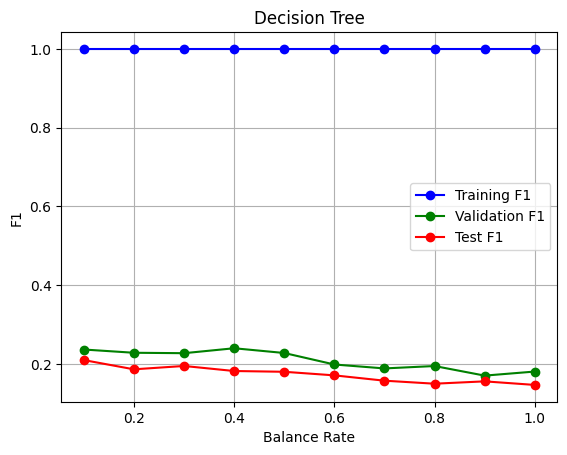

neural_network finished in 1 minutes 31.67 seconds


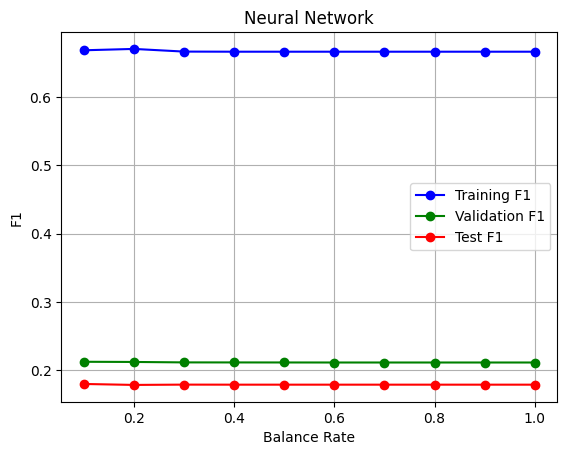

boosting finished in 5 minutes 25.12 seconds


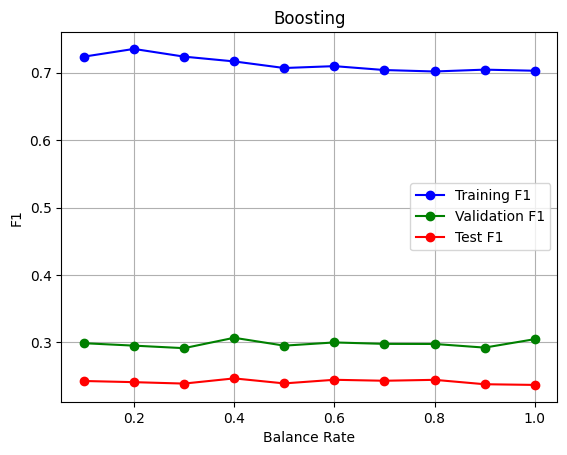

svm finished in 11 minutes 44.13 seconds


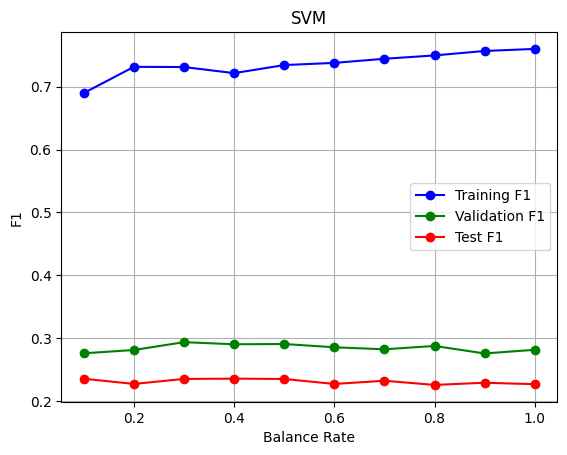

k_nearest_neighbors finished in 0 minutes 15.82 seconds


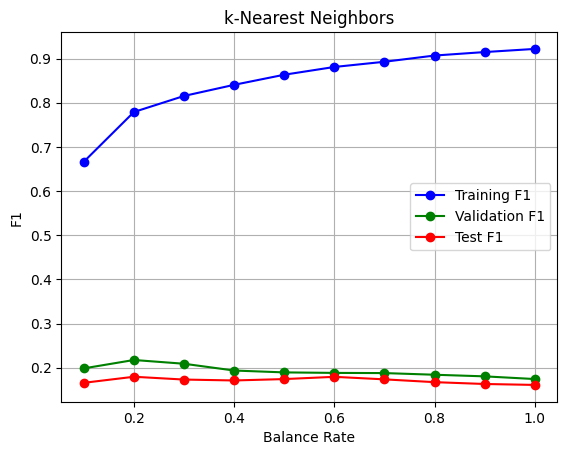

In [24]:
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=10, val=True)
all_train_f1s, all_test_f1s, all_val_f1s = train_and_plot(X_train, y_train, X_test, y_test, X_val, y_val)

In [25]:
avg_vals = np.mean(all_val_f1s, axis=0)
avg_vals

array([0.24440032, 0.24682005, 0.24652351, 0.24835234, 0.24284018,
       0.23667679, 0.23352542, 0.2350311 , 0.22595815, 0.23047442])

In [26]:
balance_rate = np.arange(0.1,1.1,0.1)
best_balance_rate = balance_rate[np.argmax(avg_vals)]
f'Best balance Val rate: {best_balance_rate}'

'Best balance Val rate: 0.4'

In [27]:
avg_tests = np.mean(all_test_f1s, axis=0)
best_balance_test_rate = balance_rate[np.argmax(avg_tests)]
f'Best balance Test rate: {best_balance_test_rate}'

'Best balance Test rate: 0.1'

In [28]:
def get_rank_df(X_train, y_train, X_test, y_test):
    model_functions = [decision_tree, neural_network, boosting, svm, k_nearest_neighbors]
    model_names = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'k-Nearest Neighbors']
    results = pd.DataFrame(columns=['Model', 'Train F1', 'Test F1'])
    for model_func, name in zip(model_functions, model_names):
        # select the best rate from last vaildation
        X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)
        train_f1, test_f1 = model_func(X_train, y_train, X_test, y_test)
        results = results.append({'Model': name, 'Train F1': train_f1, 'Test F1': test_f1}, ignore_index=True)

    results.sort_values('Test F1', inplace=True, ascending=False)
    results.reset_index(drop=True, inplace=True)
    return results


X_train, y_train, X_test, y_test = process_data(indicators=True, laglength=10, val=False)
results = get_rank_df(X_train, y_train, X_test, y_test)
results

110 leaks removed.


,Model,Train F1,Test F1
0,Boosting,0.797418,0.224818
1,SVM,0.750334,0.212917
2,Neural Network,0.667888,0.178858
3,Decision Tree,1.000000,0.176096
4,k-Nearest Neighbors,0.675958,0.165418


In [29]:
X_train, y_train, X_test, y_test = process_data(indicators=False, laglength=10, val=False)
results_without_indicators = get_rank_df(X_train, y_train, X_test, y_test)
results_without_indicators

110 leaks removed.


,Model,Train F1,Test F1
0,Boosting,0.790419,0.235460
1,SVM,0.721704,0.226340
2,Decision Tree,1.000000,0.183261
3,Neural Network,0.666844,0.179799
4,k-Nearest Neighbors,0.610294,0.175342


In [30]:
results_without_indicators = results_without_indicators.add_suffix('_without_indicators')
merged_df = pd.merge(results, results_without_indicators, left_on='Model', right_on='Model_without_indicators')
merged_df = merged_df.drop(['Model_without_indicators', 'Train F1','Train F1_without_indicators'], axis=1)
merged_df['Indicators Gain'] = merged_df['Test F1'] - merged_df['Test F1_without_indicators']
merged_df

,Model,Test F1,Test F1_without_indicators,Indicators Gain
0,Boosting,0.224818,0.235460,-0.010643
1,SVM,0.212917,0.226340,-0.013424
2,Neural Network,0.178858,0.179799,-0.000941
3,Decision Tree,0.176096,0.183261,-0.007165
4,k-Nearest Neighbors,0.165418,0.175342,-0.009924


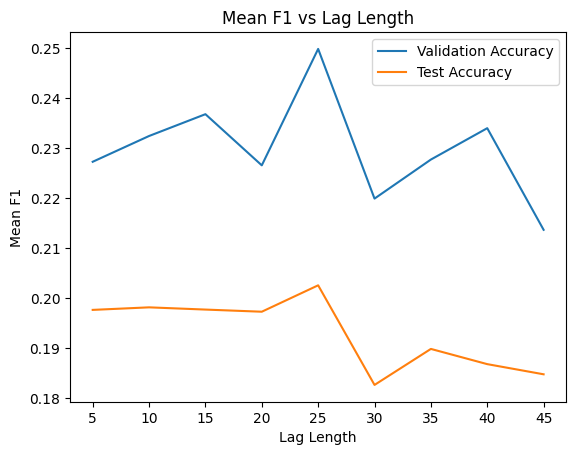

In [31]:
from sklearn.model_selection import train_test_split

def get_rank_df_val(X_train, y_train, X_test, y_test, X_val, y_val):
    model_functions = [decision_tree, neural_network, boosting, svm, k_nearest_neighbors]
    model_names = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'k-Nearest Neighbors']
    results = pd.DataFrame(columns=['Model', 'Train F1', 'Test F1'])
    for model_func, name in zip(model_functions, model_names):
        # select the best rate from last vaildation
        X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)
        train_f1, test_f1, val_f1 = model_func(X_train, y_train, X_test, y_test, X_val, y_val)
        results = results.append({'Model': name, 'Train F1': train_f1, 'Val F1': val_f1, 'Test F1': test_f1}, ignore_index=True)

    results.sort_values('Test F1', inplace=True, ascending=False)
    results.reset_index(drop=True, inplace=True)
    return results

def get_models_mean(laglength=20):
    X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
    results = get_rank_df_val(X_train, y_train, X_test, y_test, X_val, y_val)
    return results['Train F1'].mean(), results['Test F1'].mean(), results['Val F1'].mean()


scores = []
for i in np.arange(5, 50, 5):
    scores.append(get_models_mean(laglength=i))

# unpack scores
train_scores, test_scores, val_scores  = zip(*scores)

# plot
plt.plot(np.arange(5, 50, 5), val_scores, label='Validation Accuracy')
plt.plot(np.arange(5, 50, 5), test_scores, label='Test Accuracy')
plt.xlabel('Lag Length')
plt.ylabel('Mean F1')
plt.title('Mean F1 vs Lag Length')
plt.legend()
plt.show()

In [32]:
X_train, y_train, X_test, y_test = process_data(indicators=True, laglength=25, val=False, verbose=False)
results_lag_optimized = get_rank_df(X_train, y_train, X_test, y_test)
results_lag_optimized

,Model,Train F1,Test F1
0,Boosting,0.844291,0.225113
1,SVM,0.826467,0.216090
2,Decision Tree,1.000000,0.185043
3,Neural Network,0.678136,0.176420
4,k-Nearest Neighbors,0.676259,0.146357


In [33]:
results_lag_optimized = results_lag_optimized.add_suffix('_lag_optimized')
merged_df = pd.merge(results_lag_optimized, results, left_on='Model_lag_optimized', right_on='Model')
merged_df = merged_df[['Model_lag_optimized','Test F1','Test F1_lag_optimized']]
merged_df['Optimal Lag Gain'] = merged_df['Test F1_lag_optimized'] - merged_df['Test F1']
merged_df

,Model_lag_optimized,Test F1,Test F1_lag_optimized,Optimal Lag Gain
0,Boosting,0.224818,0.225113,0.000295
1,SVM,0.212917,0.216090,0.003173
2,Decision Tree,0.176096,0.185043,0.008947
3,Neural Network,0.178858,0.176420,-0.002438
4,k-Nearest Neighbors,0.165418,0.146357,-0.019061


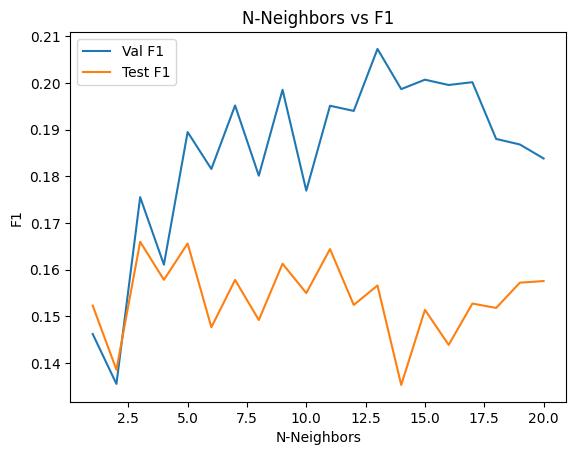

In [65]:
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=25, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)
results = pd.DataFrame(columns=['N-Neighbors', 'Train F1', 'Test F1'])
for i in range(1,21):
    train_f1, test_f1, val_f1 = k_nearest_neighbors(X_train, y_train, X_test, y_test, X_val, y_val, n_neighbors=i)
    results = results.append({'N-Neighbors': i, 'Val F1': val_f1, 'Test F1': test_f1}, ignore_index=True)

# plot
plt.plot(results['N-Neighbors'], results['Val F1'], label='Val F1')
plt.plot(results['N-Neighbors'], results['Test F1'], label='Test F1')
plt.xlabel('N-Neighbors')
plt.ylabel('F1')
plt.title('N-Neighbors vs F1')
plt.legend()
plt.show()

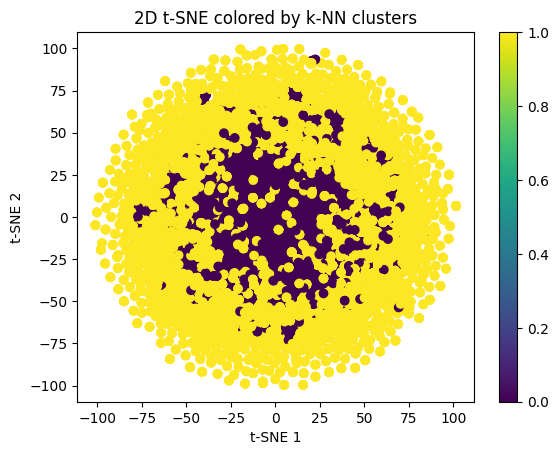

In [35]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# standardize for t-SNE
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)

# 2D t-SNE
tsne = TSNE(n_components=2)
X_train_reduced = tsne.fit_transform(X_train_standardized)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_train_reduced)

# plot
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_pred)
plt.colorbar()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('2D t-SNE colored by k-NN clusters')
plt.show()

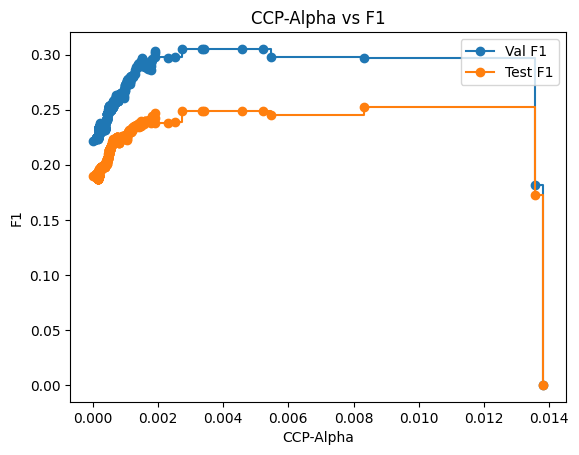

In [36]:
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=25, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

results = pd.DataFrame(columns=['CCP-Alpha', 'Train F1', 'Val F1', 'Test F1'])
path = DecisionTreeClassifier(random_state=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=20, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
    results = results.append({'CCP-Alpha': ccp_alpha, 'Train F1': train_f1, 'Val F1': val_f1, 'Test F1': test_f1}, ignore_index=True)

# plot
#plt.plot(results['CCP-Alpha'], results['Train F1'], label='Train F1', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Val F1'], label='Val F1', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Test F1'], label='Test F1', marker='o', drawstyle="steps-post")
plt.xlabel('CCP-Alpha')
plt.ylabel('F1')
plt.title('CCP-Alpha vs F1')
plt.legend()
plt.show()

In [37]:
results.iloc[results['Val F1'].idxmax()]

CCP-Alpha    0.002745
Train F1     0.658658
Val F1       0.305234
Test F1      0.249002
Name: 487, dtype: float64

In [38]:
results.iloc[results['Test F1'].idxmax()]

CCP-Alpha    0.008312
Train F1     0.575396
Val F1       0.296719
Test F1      0.252208
Name: 493, dtype: float64

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [3:21:10<00:00, 482.84s/it]


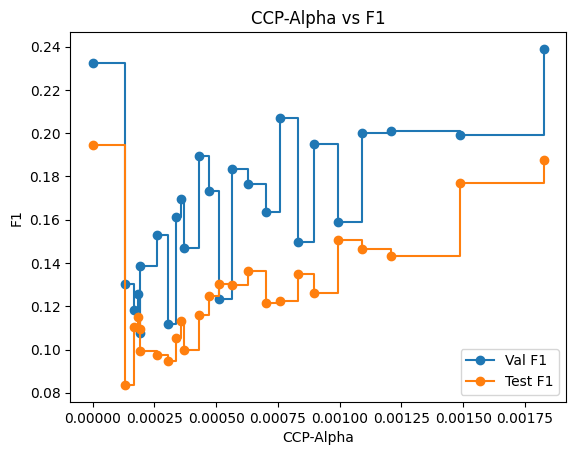

In [39]:
from tqdm import tqdm
laglength = 25
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

results = pd.DataFrame(columns=['CCP-Alpha', 'Train F1', 'Val F1', 'Test F1'])
path = DecisionTreeClassifier(random_state=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
for ccp_alpha in tqdm(ccp_alphas[::20]):
    
    base_estimator = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=20)
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
    results = results.append({'CCP-Alpha': ccp_alpha, 'Train F1': train_f1, 'Val F1': val_f1, 'Test F1': test_f1}, ignore_index=True)

# plot
#plt.plot(results['CCP-Alpha'], results['Train F1'], label='Train F1', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Val F1'], label='Val F1', marker='o', drawstyle="steps-post")
plt.plot(results['CCP-Alpha'], results['Test F1'], label='Test F1', marker='o', drawstyle="steps-post")
plt.xlabel('CCP-Alpha')
plt.ylabel('F1')
plt.title('CCP-Alpha vs F1')
plt.legend()
plt.show()

In [40]:
results.iloc[results['Val F1'].idxmax()]

CCP-Alpha    0.001826
Train F1     1.000000
Val F1       0.238949
Test F1      0.187459
Name: 24, dtype: float64

In [41]:
results.iloc[results['Test F1'].idxmax()]

CCP-Alpha    0.000000
Train F1     1.000000
Val F1       0.232389
Test F1      0.194598
Name: 0, dtype: float64

Running 50
Running 100
Running 150
Running 200


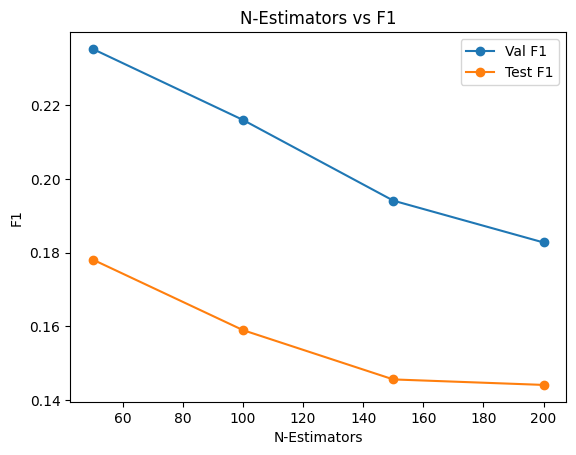

In [58]:
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

results = pd.DataFrame(columns=['N-Estimators', 'Train F1', 'Val F1', 'Test F1'])

n_estimators = [50, 100, 150, 200]  # specify a list of n_estimators to try

for n in n_estimators:
    print('Running',n)
    base_estimator = DecisionTreeClassifier(ccp_alpha=0.001826, random_state=20)  # adjust ccp_alpha if needed
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
    results = results.append({'N-Estimators': n, 'Train F1': train_f1, 'Val F1': val_f1, 'Test F1': test_f1}, ignore_index=True)

# plot
#plt.plot(results['N-Estimators'], results['Train F1'], label='Train F1', marker='o')
plt.plot(results['N-Estimators'], results['Val F1'], label='Val F1', marker='o')
plt.plot(results['N-Estimators'], results['Test F1'], label='Test F1', marker='o')
plt.xlabel('N-Estimators')
plt.ylabel('F1')
plt.title('N-Estimators vs F1')
plt.legend()
plt.show()

In [59]:
results.iloc[results['Val F1'].idxmax()]

N-Estimators    50.000000
Train F1         1.000000
Val F1           0.235294
Test F1          0.178138
Name: 0, dtype: float64

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


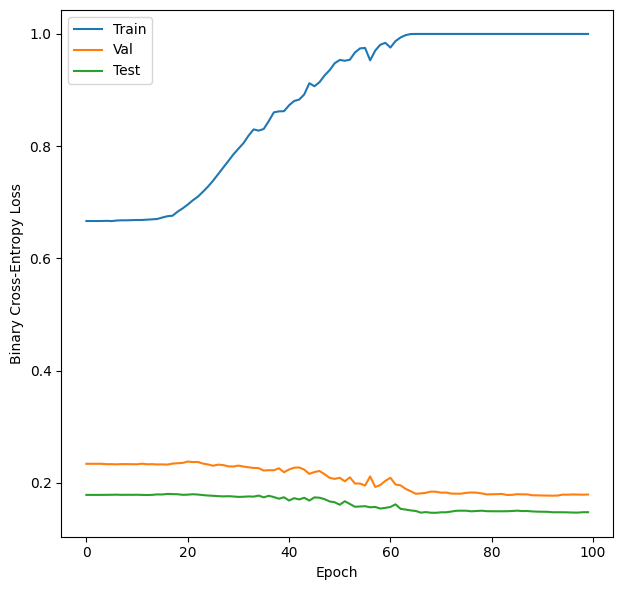

In [44]:
from tqdm import tqdm

X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 100
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)

initializer = tf.keras.initializers.GlorotUniform(seed=20)
model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
for _ in range(mlp_depth):
    model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_f1s = []
val_f1s = []
test_f1s = []

for epoch in tqdm(range(epochs)):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val), shuffle=False)
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_val = model.predict(X_val, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
        
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)


# plot losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_f1s, label='Train')
plt.plot(val_f1s, label='Val')
plt.plot(test_f1s, label='Test')
plt.xlabel('Epoch')
plt.ylabel('F1 Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
np.argmax(val_f1s)+1

21

In [46]:
initializer = tf.keras.initializers.GlorotUniform(seed=20)
laglength=25

In [47]:
from tqdm import tqdm

X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 21
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)


train_f1s = []
val_f1s = []
test_f1s = []

for hidden in tqdm([50,100,200,300,400,500,600]):
    model = Sequential()
    model.add(LSTM(hidden, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_val = model.predict(X_val, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
        
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)
    
results = pd.DataFrame({
    'Hidden Units':[50,100,200,300,400,500,600],
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Test F1': test_f1s,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [05:36<00:00, 48.03s/it]


,Hidden Units,Train F1,Validation F1,Test F1
0,50,0.695116,0.232790,0.177251
1,100,0.695962,0.238070,0.179114
2,200,0.677998,0.236300,0.178418
3,300,0.674129,0.233366,0.178910
4,400,0.676878,0.235530,0.179173
5,500,0.667104,0.234432,0.178872
6,600,0.668726,0.233938,0.178953


In [48]:
from tqdm import tqdm

X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 21
batch_size = 32

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)

train_f1s = []
val_f1s = []
test_f1s = []

for batch_size in tqdm([16,32,64,128]):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val))
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_val = model.predict(X_val, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
        
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)
    
results = pd.DataFrame({
    'Batch Size':[16,32,64,128],
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Test F1': test_f1s,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.46s/it]


,Batch Size,Train F1,Validation F1,Test F1
0,16,1.000000,0.194559,0.143018
1,32,1.000000,0.201258,0.134897
2,64,0.998821,0.210920,0.145134
3,128,0.990860,0.204358,0.143213


In [49]:
from tqdm import tqdm

X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 21
batch_size = 64

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)

train_f1s = []
val_f1s = []
test_f1s = []

for depth in tqdm([1,2,3,4,5,6,7,8,9]):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_val = model.predict(X_val, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
        
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)
    
results = pd.DataFrame({
    'MLP-Depth':[1,2,3,4,5,6,7,8,9],
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Test F1': test_f1s,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:27<00:00, 16.38s/it]


,MLP-Depth,Train F1,Validation F1,Test F1
0,1,0.687435,0.237045,0.181695
1,2,0.666667,0.234089,0.178691
2,3,0.666667,0.234089,0.178691
3,4,0.666667,0.234089,0.178691
4,5,0.666667,0.234089,0.178691
5,6,0.666667,0.234089,0.178691
6,7,0.666667,0.234089,0.178691
7,8,0.666667,0.234089,0.178691
8,9,0.666667,0.234089,0.178691


In [50]:
from tqdm import tqdm
from keras.optimizers import Adam

X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)


# hyperparameters
hidden_units = 100
mlp_depth = 1
epochs = 21
batch_size = 64

laglength = int(X_train.columns.tolist()[-1].split('-')[1])
X_train = df_to_tensor(X_train, laglength=laglength)
X_test = df_to_tensor(X_test, laglength=laglength)
X_val = df_to_tensor(X_val, laglength=laglength)


train_f1s = []
val_f1s = []
test_f1s = []

for lr in tqdm([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]):
    optimizer = Adam(learning_rate=lr)
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_val = model.predict(X_val, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
        
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)
    
results = pd.DataFrame({
    'Learning Rate':['1e-1','1e-2','1e-3','1e-4','1e-5','1e-6'],
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Test F1': test_f1s,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.25s/it]


,Learning Rate,Train F1,Validation F1,Test F1
0,1e-1,0.670354,0.234656,0.178119
1,1e-2,0.737200,0.232783,0.176394
2,1e-3,0.687949,0.238227,0.180198
3,1e-4,0.667967,0.230618,0.180280
4,1e-5,0.587000,0.223754,0.166610
5,1e-6,0.548139,0.216832,0.165965


In [51]:
X_train, y_train, X_test, y_test, X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

train_f1s = []
val_f1s = []
test_f1s = []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in tqdm(kernels):
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
    
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)

results = pd.DataFrame({
    'Kernel': kernels,
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Test F1': test_f1s,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:26<00:00, 51.75s/it]


,Kernel,Train F1,Validation F1,Test F1
0,linear,0.664504,0.326113,0.277234
1,poly,0.823349,0.290831,0.018311
2,rbf,0.795695,0.302035,0.230467
3,sigmoid,0.550479,0.256210,0.036072


In [52]:
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)

train_f1s = []
val_f1s = []
test_f1s = []

C = [0.01, 0.1, 1, 10, 100, 1000]


for c in tqdm(C):
    clf = SVC(C=c, kernel='linear')
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_val = clf.predict(X_val)
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    val_f1 = f1_score(y_val, y_pred_val)
    
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    test_f1s.append(test_f1)

    
results = pd.DataFrame({
    'C': C,
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Test F1': test_f1s,
    })
results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [1:53:53<00:00, 1138.95s/it]


,C,Train F1,Validation F1,Test F1
0,0.01,0.638360,0.323457,0.273340
1,0.10,0.658261,0.327295,0.274006
2,1.00,0.664504,0.326113,0.277234
3,10.00,0.671202,0.330539,0.273204
4,100.00,0.675132,0.329497,0.269565
5,1000.00,0.675973,0.320194,0.269900


In [53]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
warnings.filterwarnings('ignore')

import time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def decision_tree(X_train, y_train, X_test, y_test, X_val=None, y_val=None,):
    clf = DecisionTreeClassifier(random_state=20, ccp_alpha=0.0167)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1


def df_to_tensor(df, laglength=10):
    base_features = [col for col in df.columns.tolist() if '-' not in col]
    
    time_lags = range(1, laglength+1)

    ordered_columns = []
    ordered_columns += base_features
    for t in time_lags:
        ordered_columns += [f'{feature}_t-{t}' for feature in base_features]
        
    df_ordered = df[ordered_columns]
    return df_ordered.values.reshape(-1, 1, df_ordered.shape[1])

# LTSM implmentation
def neural_network(X_train, y_train, X_test, y_test, X_val=None, y_val=None, hidden_units=500, epochs=5, batch_size=64, mlp_depth=9):
    optimizer = Adam(learning_rate=1e-3)
    laglength = int(X_train.columns.tolist()[-1].split('-')[1])
    X_train = df_to_tensor(X_train, laglength=laglength)
    X_test = df_to_tensor(X_test, laglength=laglength)
    
    
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=initializer))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu', kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializer))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    
    y_pred_train = (y_pred_train > 0.5).astype(int)
    y_pred_test = (y_pred_test > 0.5).astype(int)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    if X_val is not None:
        X_val = df_to_tensor(X_val, laglength=laglength)
        y_pred_val = model.predict(X_val, verbose=0)
        y_pred_val = (y_pred_val > 0.5).astype(int)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1


def boosting(X_train, y_train, X_test, y_test, X_val=None, y_val=None,n_estimators=150):
    base_estimator = DecisionTreeClassifier(ccp_alpha=0.000520, random_state=20)
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, random_state=20)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1

def svm(X_train, y_train, X_test, y_test, X_val=None, y_val=None, kernel='linear'):
    clf = SVC(C=10, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1

def k_nearest_neighbors(X_train, y_train, X_test, y_test, X_val=None, y_val=None, n_neighbors=5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    if X_val is not None:
        y_pred_val = clf.predict(X_val)
        val_f1 = f1_score(y_val, y_pred_val)
        return train_f1, test_f1, val_f1
    else:
        return train_f1, test_f1


In [68]:
X_train, y_train, X_test, y_test  = process_data(indicators=True, laglength=laglength, val=False, verbose=False)

results = get_rank_df(X_train, y_train, X_test, y_test)
results

,Model,Train F1,Test F1
0,Boosting,0.844291,0.225113
1,SVM,0.826467,0.216090
2,Decision Tree,1.000000,0.185043
3,Neural Network,0.678136,0.176420
4,k-Nearest Neighbors,0.676259,0.146357


In [69]:
merged_df = pd.merge(results, results_without_indicators, left_on='Model', right_on='Model_without_indicators')
merged_df = merged_df.drop(['Model_without_indicators', 'Train F1','Train F1_without_indicators'], axis=1)
merged_df['Hyperparameters Optimization Gain'] = merged_df['Test F1'] - merged_df['Test F1_without_indicators']
merged_df

,Model,Test F1,Test F1_without_indicators,Hyperparameters Optimization Gain
0,Boosting,0.225113,0.235460,-0.010347
1,SVM,0.216090,0.226340,-0.010250
2,Decision Tree,0.185043,0.183261,0.001782
3,Neural Network,0.176420,0.179799,-0.003379
4,k-Nearest Neighbors,0.146357,0.175342,-0.028985


In [56]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
warnings.filterwarnings('ignore')

import time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def decision_tree(X_train, y_train, X_test, y_test, X_val=None, y_val=None,):
    clf = DecisionTreeClassifier(random_state=20, ccp_alpha=0.002745)
    clf.fit(X_train, y_train)
    return clf


def df_to_tensor(df, laglength=10):
    base_features = [col for col in df.columns.tolist() if '-' not in col]
    
    time_lags = range(1, laglength+1)

    ordered_columns = []
    ordered_columns += base_features
    for t in time_lags:
        ordered_columns += [f'{feature}_t-{t}' for feature in base_features]
        
    df_ordered = df[ordered_columns]
    return df_ordered.values.reshape(-1, 1, df_ordered.shape[1])

# LTSM implmentation
def neural_network(X_train, y_train, X_test, y_test, X_val=None, y_val=None, hidden_units=100, epochs=21, batch_size=64, mlp_depth=1):
    optimizer = Adam(learning_rate=1e-3)
    laglength = int(X_train.columns.tolist()[-1].split('-')[1])
    X_train = df_to_tensor(X_train, laglength=laglength)
    X_test = df_to_tensor(X_test, laglength=laglength)
    
    
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    for _ in range(mlp_depth):
        model.add(Dense(X_train.shape[2], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model


def boosting(X_train, y_train, X_test, y_test, X_val=None, y_val=None,n_estimators=150):
    base_estimator = DecisionTreeClassifier(ccp_alpha=0.001826)
    clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    return clf

def svm(X_train, y_train, X_test, y_test, X_val=None, y_val=None, kernel='linear'):
    clf = SVC(C=10, kernel=kernel)
    clf.fit(X_train, y_train)
    return clf

def k_nearest_neighbors(X_train, y_train, X_test, y_test, X_val=None, y_val=None, n_neighbors=5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    return clf

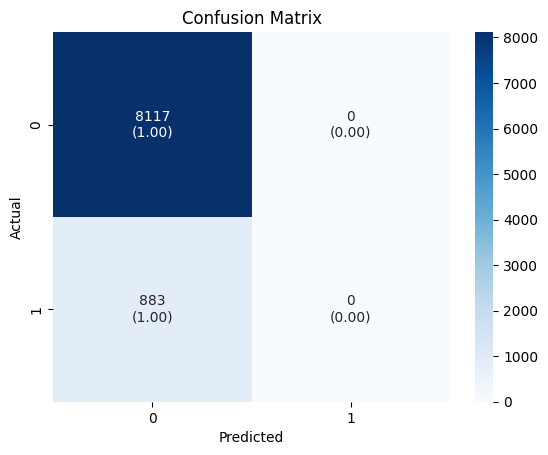

decision_tree finished in 0 minutes 4.35 seconds
282/282 [==============================] - 0s 731us/step


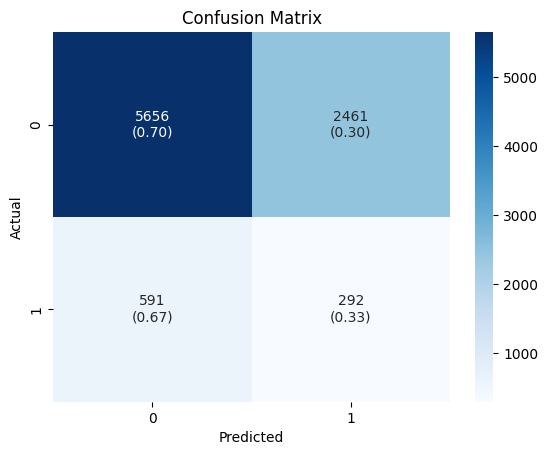

neural_network finished in 0 minutes 5.09 seconds


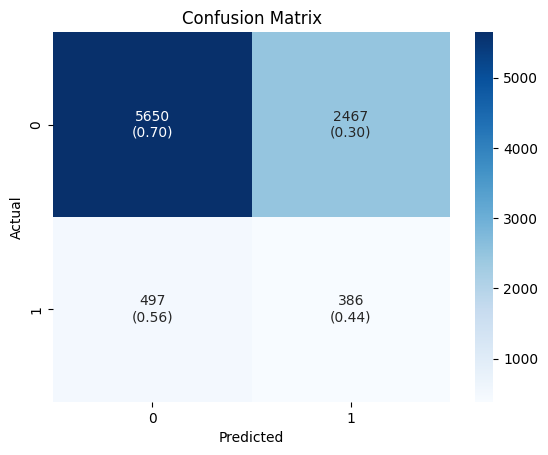

boosting finished in 0 minutes 0.87 seconds


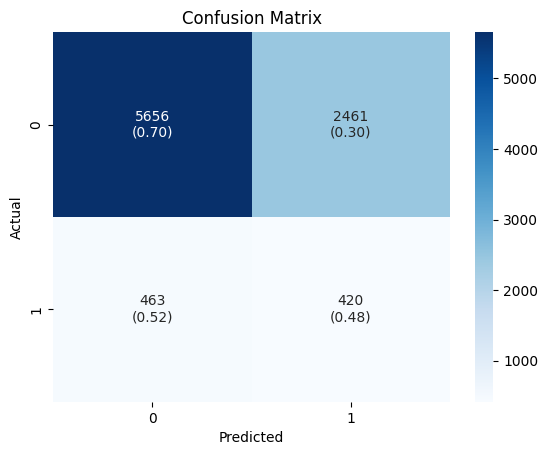

svm finished in 0 minutes 1.42 seconds


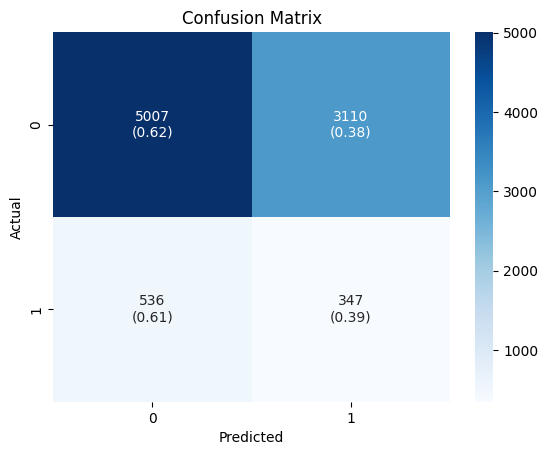

k_nearest_neighbors finished in 0 minutes 0.5 seconds


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
        
        
X_train, y_train, X_test, y_test , X_val, y_val = process_data(indicators=True, laglength=laglength, val=True, verbose=False)
model_functions = [decision_tree, neural_network, boosting, svm, k_nearest_neighbors]
model_names = ['Decision Tree', 'Neural Network', 'Boosting', 'SVM', 'k-Nearest Neighbors']

for model_func, name in zip(model_functions, model_names):
    start = time.time()
    # select the best rate from last vaildation
    X_train, y_train = balance_df(X_train, y_train, rate=best_balance_rate)
    model = model_func(X_train, y_train, X_test, y_test)
    
    if name == 'Neural Network':
        y_pred = model.predict(df_to_tensor(X_test, laglength=laglength))
        y_pred = (y_pred > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot = np.array([["{}\n({:.2f})".format(cm[i, j], cm_norm[i, j]) for j in range(cm.shape[1])] for i in range(cm.shape[0])])
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    end = time.time()
    minutes, seconds = divmod(end - start, 60)
    print(f"{model_func.__name__} finished in {int(minutes)} minutes {round(seconds,2)} seconds")

results.sort_values('Test F1', inplace=True, ascending=False)
results.reset_index(drop=True, inplace=True)